In [1]:
pip install psycopg2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn = ps.connect (dbname = "capstonedb",
                  user = "postgres",
                  password = "123456",
                  port = "5432")

# KATEGORİ BAZLI CİRO ANALİZİ

In [4]:
sql = """SELECT c.category_id, c.category_name, 
       CAST(SUM(od.quantity * od.unit_price) AS NUMERIC(10,2)) AS total_sales
FROM order_details od
JOIN products p ON od.product_id = p.product_id
JOIN categories c ON p.category_id = c.category_id
GROUP BY c.category_id, c.category_name
ORDER BY total_sales DESC"""


In [5]:
df = sqlio.read_sql_query(sql, conn)
df.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_14180\2184680693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql, conn)


,category_id,category_name,total_sales
0,1,Beverages,286526.95
1,4,Dairy Products,251330.50
2,6,Meat/Poultry,178188.80
3,3,Confections,177099.10
4,8,Seafood,141623.09


In [6]:
df.shape

(8, 3)

In [7]:
#TOPLAM CİRO

sql6 = """-- 3) Genel Toplam Ciro Analizi: 
SELECT
    ROUND(SUM(od.quantity * od.unit_price)::numeric, 2) AS total_revenue
FROM
    orders o
INNER JOIN
    order_details od ON o.order_id = od.order_id
"""

In [8]:
df6 = sqlio.read_sql_query(sql6, conn)
df6.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_14180\3910826175.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df6 = sqlio.read_sql_query(sql6, conn)


,total_revenue
0,1354458.59


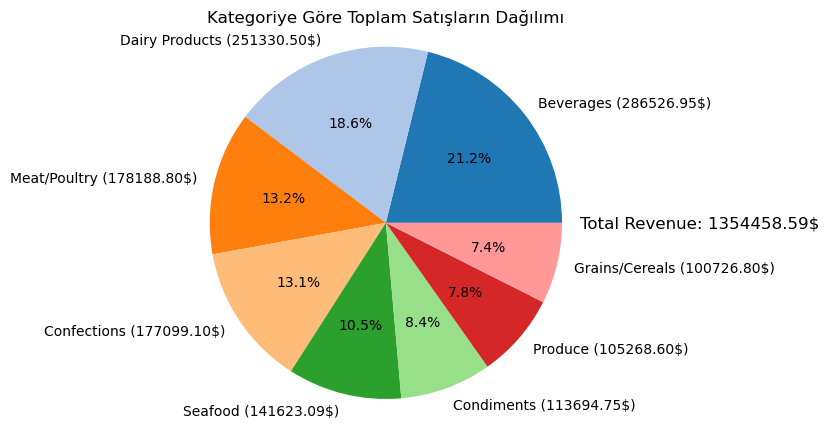

In [9]:
df_category_sales = pd.DataFrame({
    'Category': ['Beverages', 'Dairy Products', 'Meat/Poultry', 'Confections', 'Seafood','Condiments','Produce','Grains/Cereals'],
    'Total Sales': [286526.95, 251330.50, 178188.80, 177099.10, 141623.09, 113694.75, 105268.60, 100726.80]
})

total_revenue = 1354458.59

plt.figure(figsize=(5, 5))

plt.pie(df_category_sales['Total Sales'], labels=[f"{cat} ({sales:.2f}$)" for cat, sales in zip(df_category_sales['Category'], df_category_sales['Total Sales'])], autopct='%1.1f%%', colors=plt.cm.tab20.colors)

# Dairenin yan tarafına total_revenue değerini yazdım.
plt.text(1.1, 0, f'Total Revenue: {total_revenue:.2f}$', horizontalalignment='left', verticalalignment='center', fontsize=12)

plt.title('Kategoriye Göre Toplam Satışların Dağılımı')
plt.axis('equal')
plt.show()


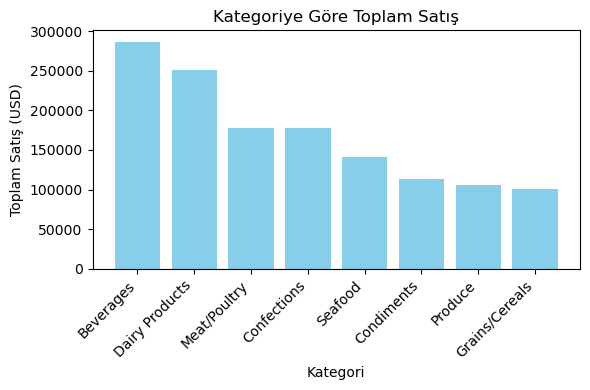

In [10]:
plt.figure(figsize=(6, 4))
plt.bar(df['category_name'], df['total_sales'], color='skyblue')
plt.xlabel('Kategori')
plt.ylabel('Toplam Satış (USD)')
plt.title('Kategoriye Göre Toplam Satış')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
#YORUM

# Her Çalışanın Hangi Kategoride Kaç Ürün Sattığını Bulma

In [12]:
sql2 = """SELECT 
    CONCAT(e.first_name, ' ', e.last_name) AS employee_full_name,
    e.title AS employee_title,
    c.category_name,
    SUM(od.quantity) AS total_quantity
FROM 
    employees e
LEFT JOIN 
    orders o ON e.employee_id = o.employee_id
LEFT JOIN 
    order_details od ON o.order_id = od.order_id
LEFT JOIN 
    products p ON od.product_id = p.product_id
LEFT JOIN 
    categories c ON p.category_id = c.category_id
GROUP BY 
    e.employee_id, e.first_name, e.last_name, c.category_name
ORDER BY 
    total_quantity DESC
"""

In [13]:
df2 = sqlio.read_sql_query(sql2, conn)
df = pd.read_sql_query(sql2, conn)
df2.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_14180\1640492934.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = sqlio.read_sql_query(sql2, conn)
C:\Users\ACER\AppData\Local\Temp\ipykernel_14180\1640492934.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql2, conn)


,employee_full_name,employee_title,category_name,total_quantity
0,Nancy Davolio,Sales Representative,Beverages,1607
1,Margaret Peacock,Sales Representative,Beverages,1572
2,Margaret Peacock,Sales Representative,Confections,1535
3,Nancy Davolio,Sales Representative,Dairy Products,1525
4,Margaret Peacock,Sales Representative,Seafood,1505


In [14]:
df2.shape

(72, 4)

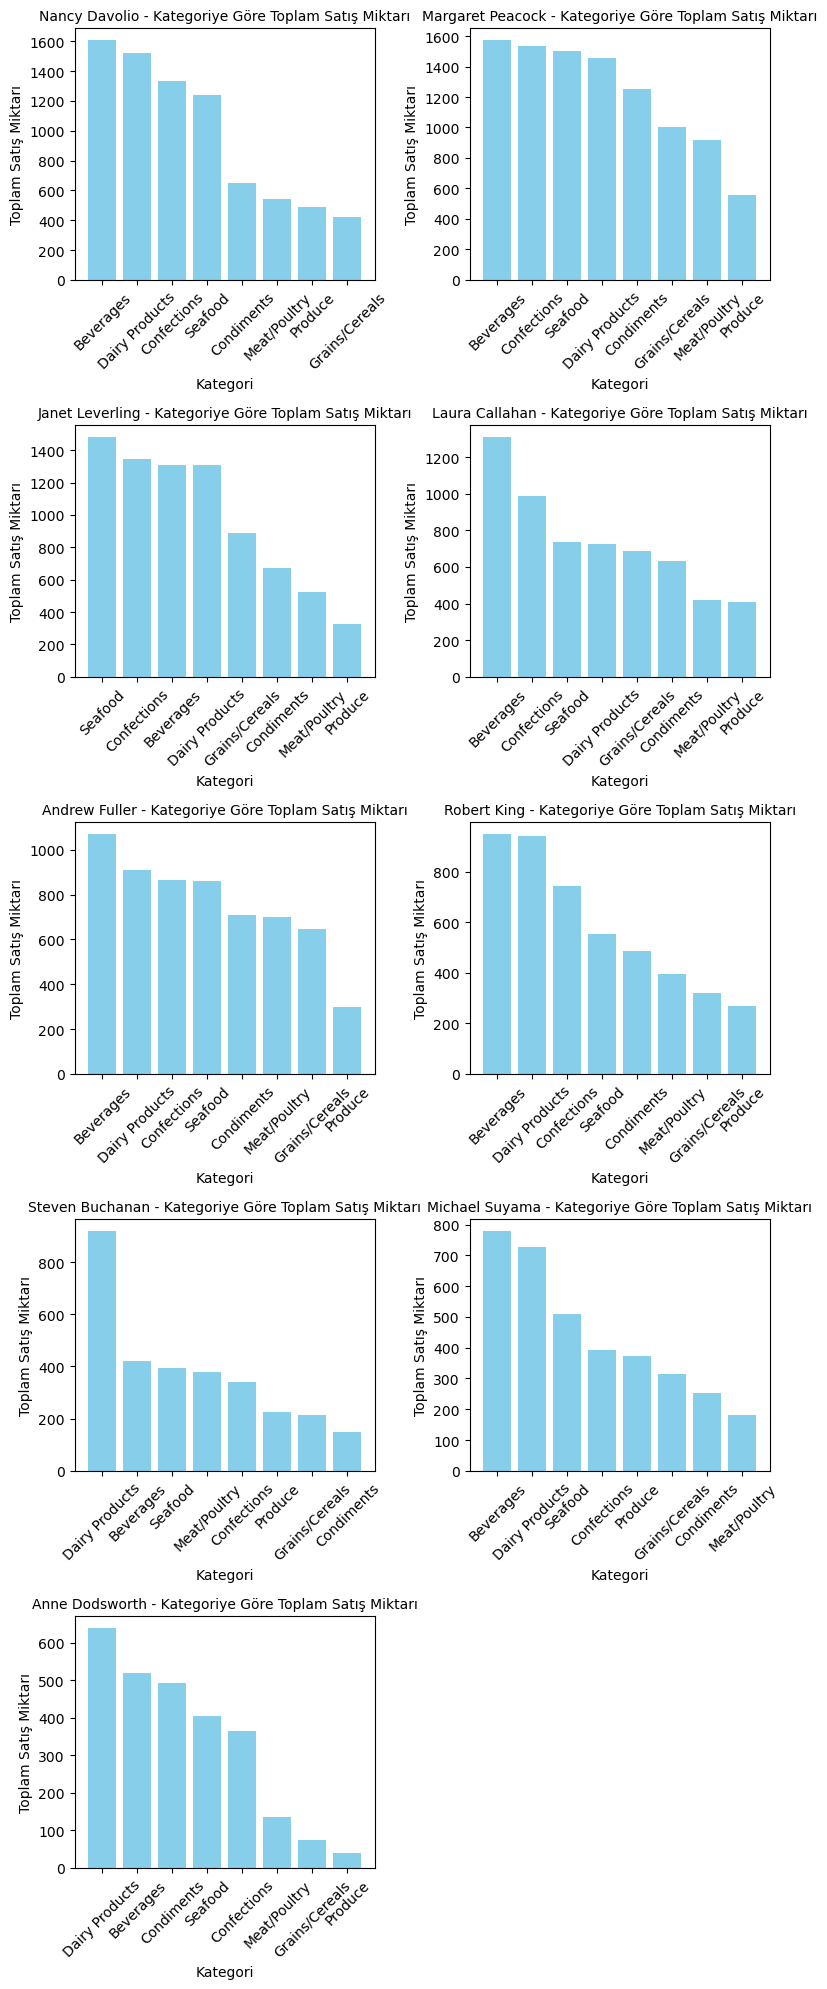

In [15]:
num_employees = len(df['employee_full_name'].unique())

num_rows = (num_employees + 1) // 2 
fig, axes = plt.subplots(num_rows, 2, figsize=(8, 4 * num_rows))

for i, employee in enumerate(df['employee_full_name'].unique(), 0):
    row = i // 2  # Satır indeksi
    col = i % 2   # Sütun indeksi
    subset = df[df['employee_full_name'] == employee]
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.bar(subset['category_name'], subset['total_quantity'], color='skyblue')
    ax.set_xlabel('Kategori')
    ax.set_ylabel('Toplam Satış Miktarı')
    ax.set_title(f'{employee} - Kategoriye Göre Toplam Satış Miktarı', fontsize=10) 
    ax.tick_params(axis='x', rotation=45)

for i in range(num_employees, num_rows * 2):
    row = i // 2  # Satır indeksi
    col = i % 2   # Sütun indeksi
    if num_rows > 1:
        fig.delaxes(axes[row, col])
    else:
        fig.delaxes(axes[col])

plt.tight_layout()
plt.show()


In [16]:
#YORUM

# MÜŞTERİ SEGMENT ANALİZİ #

In [17]:
sql4 = """SELECT 
    CASE
        WHEN total_orders > 15 THEN 'Loyal'
        WHEN total_orders > 10 THEN 'Regular'
        ELSE 'Occasional'
    END AS customer_segment,
    COUNT(customer_id) AS total_customers,
    ROUND(SUM(order_amount)::numeric, 2) AS total_sales_amount
FROM (
    SELECT 
        o.customer_id,
        COUNT(*) AS total_orders,
        SUM(od.quantity * od.unit_price) AS order_amount
    FROM 
        orders o
    INNER JOIN 
        order_details od ON o.order_id = od.order_id
    GROUP BY 
        o.customer_id
) AS order_counts
GROUP BY 
    customer_segment """

In [18]:
df4 = sqlio.read_sql_query(sql4, conn)
df = pd.read_sql_query(sql4, conn)
df4.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_14180\2765491282.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df4 = sqlio.read_sql_query(sql4, conn)
C:\Users\ACER\AppData\Local\Temp\ipykernel_14180\2765491282.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql4, conn)


,customer_segment,total_customers,total_sales_amount
0,Occasional,22,48935.38
1,Loyal,54,1242162.70
2,Regular,13,63360.51


In [19]:
df4.shape

(3, 3)

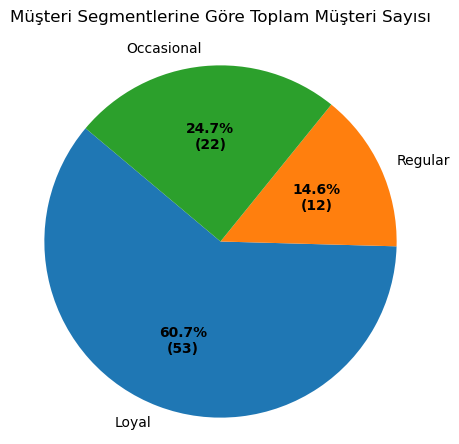

In [20]:
data = {
    'customer_segment': ['Loyal', 'Regular', 'Occasional'],
    'total_customers': [54, 13, 22],
    'total_sales_amount': [1242162.70, 63360.51, 48935.38]
}


fig, ax = plt.subplots(figsize=(5, 5))
wedges, texts, autotexts = ax.pie(data['total_customers'], labels=data['customer_segment'], autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100 * sum(data["total_customers"]))})', startangle=140)
plt.setp(autotexts, size=10, weight='bold')
plt.title('Müşteri Segmentlerine Göre Toplam Müşteri Sayısı', y=1.05) 
plt.axis('equal')
plt.show()


In [21]:
#YORUM

# MÜŞTERİ YAŞAM DÖNGÜSÜ ANALİZİ

In [22]:
sql5 = """SELECT 
    customer_lifecycle_stage,
    COUNT(customer_id) AS total_customers
FROM (
    SELECT 
        customer_id,
        CASE 
            WHEN total_orders < 5 THEN 'Acquisition'
            WHEN total_orders < 10 THEN 'Engagement'
            WHEN total_orders < 15 THEN 'Retention'
            ELSE 'Churn'
        END AS customer_lifecycle_stage
    FROM (
        SELECT 
            customer_id,
            COUNT(*) AS total_orders
        FROM 
            orders
        GROUP BY 
            customer_id
    ) AS order_counts
) AS lifecycle_stages
GROUP BY 
    customer_lifecycle_stage
"""

In [23]:
df5 = sqlio.read_sql_query(sql5, conn)
df = pd.read_sql_query(sql5, conn)
df5.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_14180\2597984963.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df5 = sqlio.read_sql_query(sql5, conn)
C:\Users\ACER\AppData\Local\Temp\ipykernel_14180\2597984963.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql5, conn)


,customer_lifecycle_stage,total_customers
0,Acquisition,16
1,Churn,12
2,Retention,27
3,Engagement,34


In [24]:
df5.shape

(4, 2)

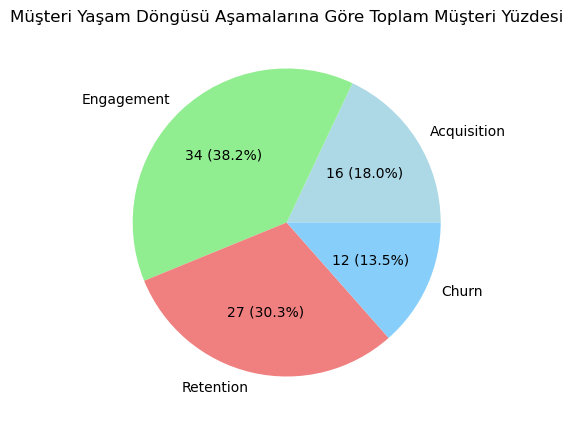

In [25]:
data = {
    'customer_lifecycle_stage': ['Acquisition', 'Engagement', 'Retention', 'Churn'],
    'total_customers': [16, 34, 27, 12]
}

df = pd.DataFrame(data)

plt.figure(figsize=(5, 5))
plt.pie(df['total_customers'], labels=df['customer_lifecycle_stage'], autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(df['total_customers']) / 100, p), colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Müşteri Yaşam Döngüsü Aşamalarına Göre Toplam Müşteri Yüzdesi')
plt.show()

In [26]:
#YORUM